# First Hitting Time Characteristic Function Demonstration

This notebook demonstrates the 12D Riccati solver for computing first hitting time characteristic functions of the Hawkes jump-diffusion process in DeFi lending analysis.

## Overview

The first hitting time characteristic function has the form:
$$\phi(s) = \mathbb{E}[e^{is\tau}]$$

where $\tau$ is the first hitting time and $s$ is the frequency parameter.

The characteristic function satisfies:
$$\phi(s) = \exp(-isA(h_0) - B(h_0)\lambda_{X0} - C(h_0)\lambda_{Y0})$$

where $A$, $B$, $C$ are solutions to the 12D second-order Riccati system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
import os

# Add src directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

from riccati_solver import FirstHittingTimeRiccatiSolver, FirstHittingTimeParameters

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

## 1. Load Model Parameters

Load parameters and initialize the first hitting time solver.

In [2]:
# Load configuration
with open('../config/model_parameters.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Extract parameters for first hitting time solver
params = FirstHittingTimeParameters(
    # Health factor parameters
    sigma_h=config['diffusion']['volatility'],
    mu_h=config['diffusion']['drift'],
    
    # Jump size parameters
    eta_X=config['jump_sizes']['eta_X'],
    delta_X=config['jump_sizes']['delta_X'],
    eta_Y=config['jump_sizes']['eta_Y'],
    delta_Y=config['jump_sizes']['delta_Y'],
    
    # Hawkes parameters
    mu_X_lambda=config['hawkes_intensities']['mu_X_lambda'],
    mu_Y_lambda=config['hawkes_intensities']['mu_Y_lambda'],
    beta_X=config['hawkes_intensities']['beta_X'],
    beta_Y=config['hawkes_intensities']['beta_Y'],
    alpha_XX=config['hawkes_intensities']['alpha_XX'],
    alpha_YY=config['hawkes_intensities']['alpha_YY'],
    alpha_XY=config['hawkes_intensities']['alpha_XY'],
    alpha_YX=config['hawkes_intensities']['alpha_YX']
)

print("First Hitting Time Model Parameters:")
print(f"Health factor volatility (σ_h): {params.sigma_h}")
print(f"Health factor drift (μ_h): {params.mu_h}")
print(f"Jump parameters (η_X, δ_X): {params.eta_X}, {params.delta_X}")
print(f"Jump parameters (η_Y, δ_Y): {params.eta_Y}, {params.delta_Y}")
print(f"Hawkes baseline intensities: {params.mu_X_lambda}, {params.mu_Y_lambda}")
print(f"Decay rates (β_X, β_Y): {params.beta_X}, {params.beta_Y}")
print(f"Self-excitation (α_XX, α_YY): {params.alpha_XX}, {params.alpha_YY}")
print(f"Cross-excitation (α_XY, α_YX): {params.alpha_XY}, {params.alpha_YX}")

First Hitting Time Model Parameters:
Health factor volatility (σ_h): 0.8
Health factor drift (μ_h): 0.01
Jump parameters (η_X, δ_X): 2.0, 0.08
Jump parameters (η_Y, δ_Y): 1.8, 0.08
Hawkes baseline intensities: 2.0, 2.0
Decay rates (β_X, β_Y): 1.5, 1.5
Self-excitation (α_XX, α_YY): 0.5, 0.6
Cross-excitation (α_XY, α_YX): 0.3, 0.3


## 2. Initialize First Hitting Time Solver

Create the solver instance with our parameters.

In [3]:
# Initialize solver
solver = FirstHittingTimeRiccatiSolver(params)

# Test initial conditions
h0 = config['health_factor']['initial_value'] - config['health_factor']['liquidation_threshold']  # Distance from liquidation
lambda_X0 = config['initial_intensities']['lambda_X0']
lambda_Y0 = config['initial_intensities']['lambda_Y0']

print("First hitting time solver initialized successfully!")
print(f"Initial health factor distance: h0 = {h0}")
print(f"Initial intensities: λ_X0 = {lambda_X0}, λ_Y0 = {lambda_Y0}")

# Test characteristic function at s=0 (should be 1)
phi_0 = solver.characteristic_function(1e-6, h0, lambda_X0, lambda_Y0)
print(f"φ(0) = {phi_0} (should be ≈ 1.0)")

First hitting time solver initialized successfully!
Initial health factor distance: h0 = 0.25
Initial intensities: λ_X0 = 2.0, λ_Y0 = 2.0
φ(0) = (0.9999989745914813+9.4540698914047e-08j) (should be ≈ 1.0)


## 3. Characteristic Function Analysis

Compute and visualize the first hitting time characteristic function for different frequency parameters.

In [4]:
# Compute characteristic function for different frequencies
s_values = np.linspace(-5, 5, 100)
phi_values = []

print("Computing characteristic function values...")
for i, s in enumerate(s_values):
    if i % 20 == 0:
        print(f"Progress: {i/len(s_values)*100:.1f}%")
    
    try:
        phi = solver.characteristic_function(s, h0, lambda_X0, lambda_Y0)
        phi_values.append(phi)
    except RuntimeError as e:
        print(f"Failed for s = {s}: {e}")
        phi_values.append(np.nan + 1j * np.nan)

phi_values = np.array(phi_values)
print(f"Computed {len(phi_values)} characteristic function values")

Computing characteristic function values...
Progress: 0.0%
Progress: 20.0%
Progress: 40.0%
Progress: 60.0%
Progress: 80.0%
Computed 100 characteristic function values


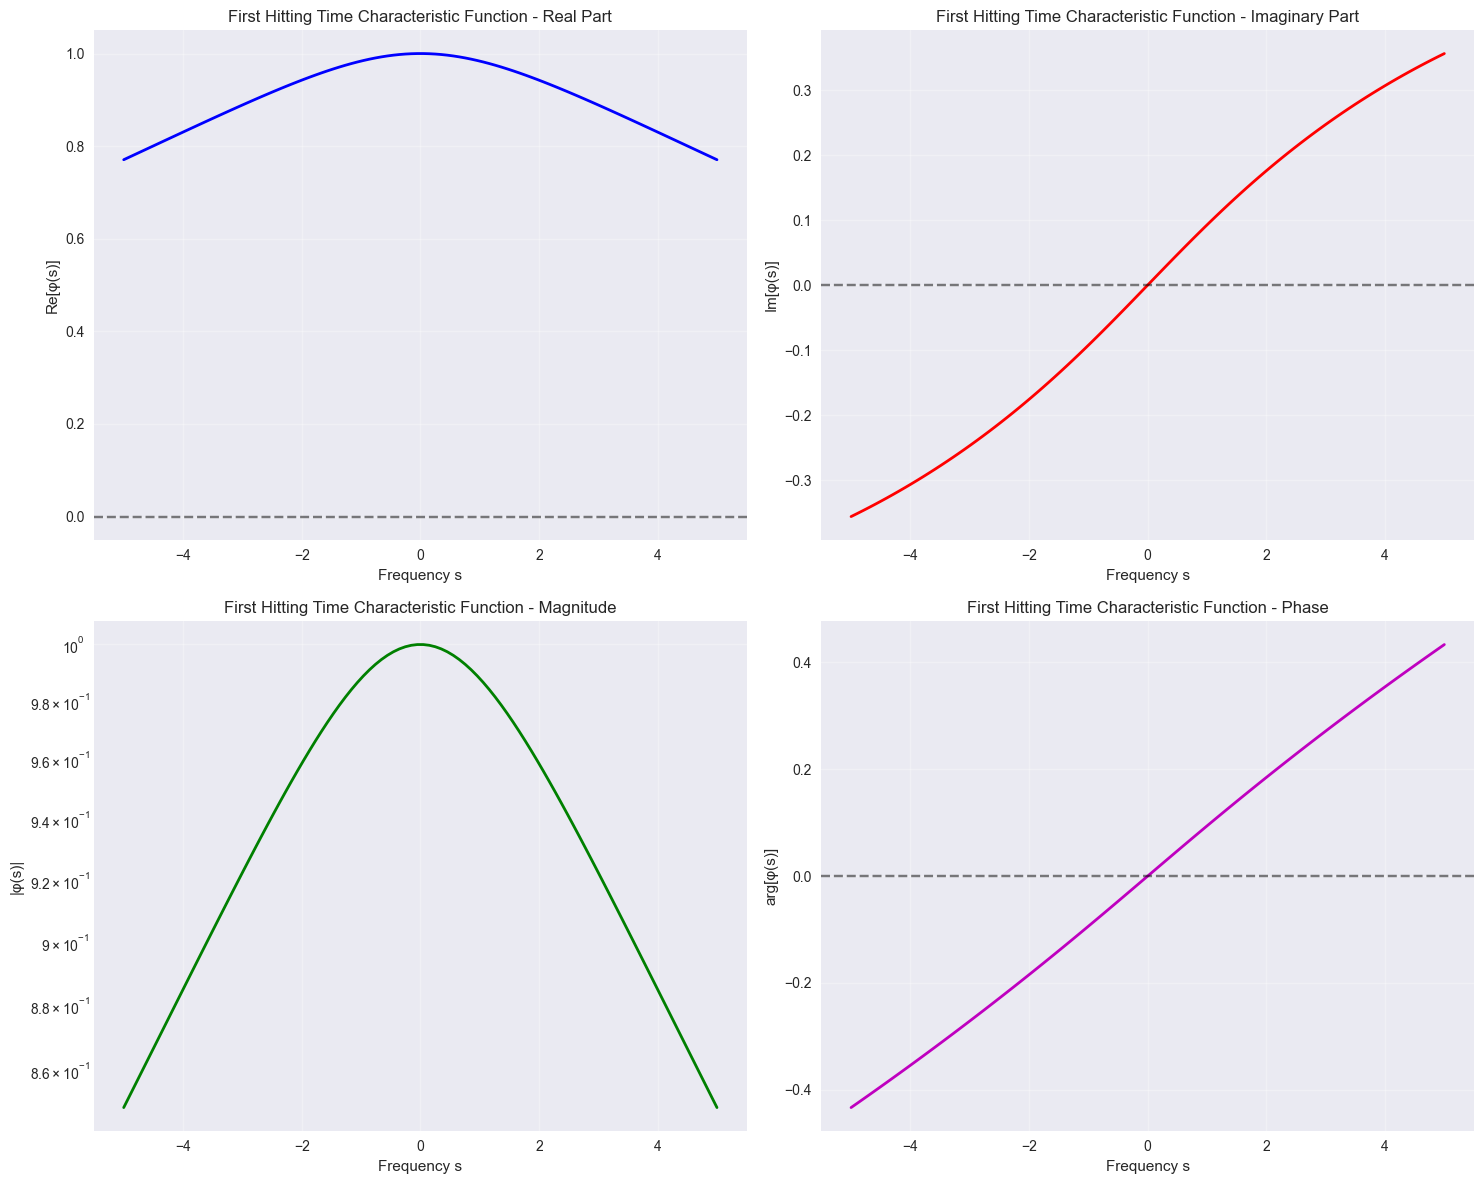

In [5]:
# Plot characteristic function
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Real and imaginary parts
axes[0, 0].plot(s_values, phi_values.real, 'b-', linewidth=2, label='Real part')
axes[0, 0].set_xlabel('Frequency s')
axes[0, 0].set_ylabel('Re[φ(s)]')
axes[0, 0].set_title('First Hitting Time Characteristic Function - Real Part')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)

axes[0, 1].plot(s_values, phi_values.imag, 'r-', linewidth=2, label='Imaginary part')
axes[0, 1].set_xlabel('Frequency s')
axes[0, 1].set_ylabel('Im[φ(s)]')
axes[0, 1].set_title('First Hitting Time Characteristic Function - Imaginary Part')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Magnitude and phase
magnitude = np.abs(phi_values)
valid_mag = magnitude[~np.isnan(magnitude)]
if len(valid_mag) > 0:
    axes[1, 0].semilogy(s_values, magnitude, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Frequency s')
    axes[1, 0].set_ylabel('|φ(s)|')
    axes[1, 0].set_title('First Hitting Time Characteristic Function - Magnitude')
    axes[1, 0].grid(True, alpha=0.3)

phase = np.angle(phi_values)
axes[1, 1].plot(s_values, phase, 'm-', linewidth=2)
axes[1, 1].set_xlabel('Frequency s')
axes[1, 1].set_ylabel('arg[φ(s)]')
axes[1, 1].set_title('First Hitting Time Characteristic Function - Phase')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 4. First Hitting Time Distribution (CDF and PDF)

Use the Gil-Pelaez inversion formula to compute the CDF and PDF of the first hitting time.

In [ ]:
# Compute CDF for different time points
min_T = 0.001  # Minimum time
max_T = 1.0    # Maximum time
num_points = 10  # Number of points to compute

T_values = np.linspace(min_T, max_T, num_points)
cdf_values = []
pdf_values = []

print("Computing first hitting time CDF and PDF...")
for i, T in enumerate(T_values):
    

    # CDF using Gil-Pelaez inversion
    cdf = solver.gil_pelaez_cdf(T, h0, lambda_X0, lambda_Y0, s_max=50, n_points=500)
    cdf_values.append(cdf)

    # PDF using numerical differentiation
    pdf = solver.first_passage_pdf(T, h0, lambda_X0, lambda_Y0, dT=(max_T-min_T)/num_points)
    pdf_values.append(pdf)
    
    print(f"T = {T:.4f}, CDF = {cdf:.4f}, PDF = {pdf:.4f}")


cdf_values = np.array(cdf_values)
pdf_values = np.array(pdf_values)

print(f"CDF range: [{cdf_values.min():.4f}, {cdf_values.max():.4f}]")
print(f"PDF range: [{pdf_values.min():.4f}, {pdf_values.max():.4f}]")

Computing first hitting time CDF and PDF...
T = 0.0010, CDF = 0.0720, PDF = 5.9009
T = 0.1120, CDF = 0.7119, PDF = 4.1447
T = 0.2230, CDF = 0.9012, PDF = 0.5593
T = 0.3340, CDF = 0.9537, PDF = 0.3541
T = 0.4450, CDF = 0.9730, PDF = 0.1866
T = 0.5560, CDF = 0.9824, PDF = 0.0971
T = 0.6670, CDF = 0.9884, PDF = 0.0531
T = 0.7780, CDF = 0.9929, PDF = 0.0302
T = 0.8890, CDF = 0.9962, PDF = 0.0183
T = 1.0000, CDF = 0.9984, PDF = 0.0131
CDF range: [0.0720, 0.9984]


AttributeError: 'list' object has no attribute 'min'

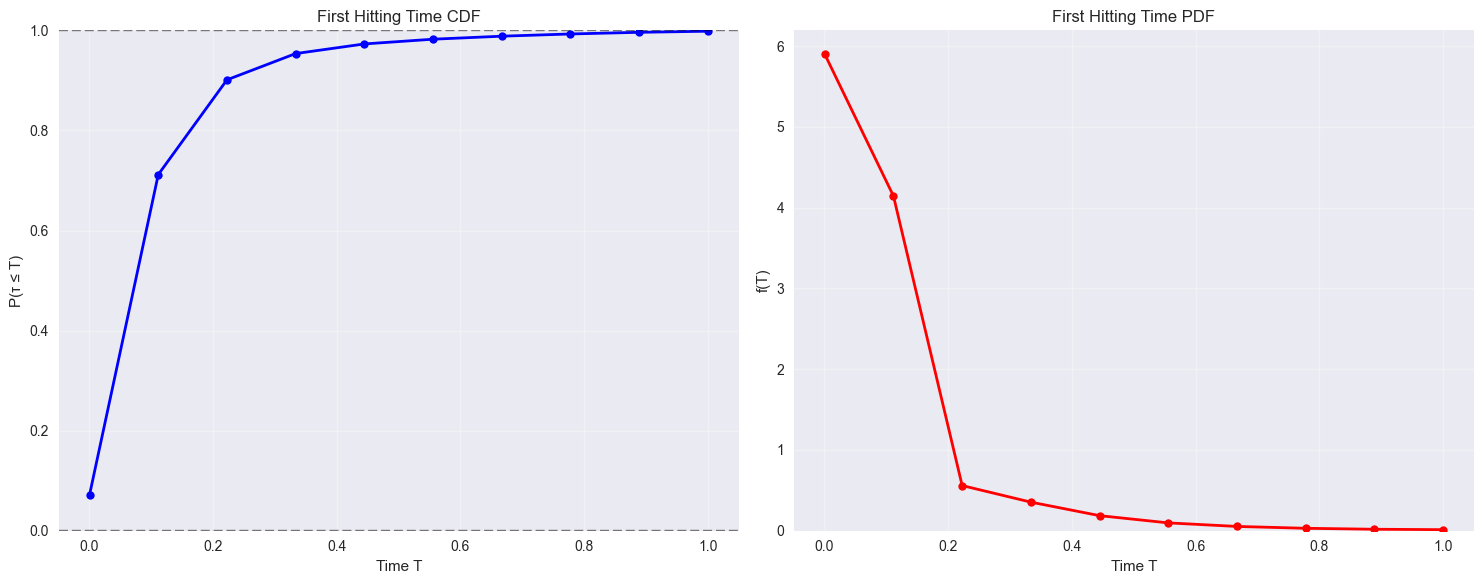

Probability of hitting within T=1: 0.9983
Probability of hitting within T=5: 1.0000
Survival probability at T=1: 0.0017
Survival probability at T=5: 0.0000


In [7]:
# Plot CDF and PDF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# CDF plot
axes[0].plot(T_values, cdf_values, 'b-o', linewidth=2, markersize=6)
axes[0].set_xlabel('Time T')
axes[0].set_ylabel('P(τ ≤ T)')
axes[0].set_title('First Hitting Time CDF')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Add theoretical bounds
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[0].axhline(y=1, color='k', linestyle='--', alpha=0.5)

# PDF plot
axes[1].plot(T_values, pdf_values, 'r-o', linewidth=2, markersize=6)
axes[1].set_xlabel('Time T')
axes[1].set_ylabel('f(T)')
axes[1].set_title('First Hitting Time PDF')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print some key statistics
print(f"Probability of hitting within T=1: {solver.gil_pelaez_cdf(1.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Probability of hitting within T=5: {solver.gil_pelaez_cdf(5.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Survival probability at T=1: {solver.survival_function(1.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Survival probability at T=5: {solver.survival_function(5.0, h0, lambda_X0, lambda_Y0):.4f}")

## 5. Moments of First Hitting Time

Compute the first few moments of the first hitting time distribution.

In [8]:
# Compute moments
print("Computing moments of first hitting time distribution...")
moments = solver.moments(h0, lambda_X0, lambda_Y0, max_moment=2)

print("\nFirst Hitting Time Moments:")
print("=" * 40)
for key, value in moments.items():
    if not np.isnan(value):
        print(f"{key}: {value:.6f}")
    else:
        print(f"{key}: Not computed")

# Compare with some analytical bounds if available
if 'moment_1' in moments and not np.isnan(moments['moment_1']):
    mean_fht = moments['moment_1']
    print(f"\nMean first hitting time: {mean_fht:.4f} time units")
    
    if 'std_dev' in moments and not np.isnan(moments['std_dev']):
        std_fht = moments['std_dev']
        print(f"Standard deviation: {std_fht:.4f} time units")
        print(f"Coefficient of variation: {std_fht/mean_fht:.4f}")

Computing moments of first hitting time distribution...

First Hitting Time Moments:
moment_1: 0.094541
moment_2: -97364.661888
variance: -97364.670826
std_dev: 0.000000

Mean first hitting time: 0.0945 time units
Standard deviation: 0.0000 time units
Coefficient of variation: 0.0000


## 6. Parameter Sensitivity Analysis

Analyze how changes in key parameters affect the first hitting time distribution.

In [9]:
# Sensitivity analysis for different initial health factor values
h0_values = np.linspace(0.1, 2, 20)  # Example values
T_test = 0.5

sensitivity_results = {
    'h0_values': h0_values,
    'cdf_at_T': [],
    'survival_at_T': [],
    'mean_hitting_time': []
}

print(f"Sensitivity analysis for T = {T_test}:")
print("h0\t\tP(τ≤T)\t\tP(τ>T)\t\tE[τ]")
print("-" * 75)

for h0_test in h0_values:
    # CDF and survival function
    cdf = solver.gil_pelaez_cdf(T_test, h0_test, lambda_X0, lambda_Y0)
    survival = solver.survival_function(T_test, h0_test, lambda_X0, lambda_Y0)
    
    # Mean hitting time
    moments_test = solver.moments(h0_test, lambda_X0, lambda_Y0, max_moment=1)
    mean_ht = moments_test.get('moment_1', np.nan)
    
    sensitivity_results['cdf_at_T'].append(cdf)
    sensitivity_results['survival_at_T'].append(survival)
    sensitivity_results['mean_hitting_time'].append(mean_ht)
    
    print(f"{h0_test:.2f}\t\t{cdf:.4f}\t\t{survival:.4f}\t\t{mean_ht:.4f}")

Sensitivity analysis for T = 0.5:
h0		P(τ≤T)		P(τ>T)		E[τ]
---------------------------------------------------------------------------
0.10		1.0000		0.0000		0.0154
0.20		0.9886		0.0114		0.0609
0.30		0.9511		0.0489		0.1352
0.40		0.8527		0.1473		0.2370
0.50		0.7344		0.2656		0.3646
0.60		0.6334		0.3666		0.5163
0.70		0.5582		0.4418		0.6899
0.80		0.5079		0.4921		0.8825
0.90		0.4785		0.5215		1.0906
1.00		0.4662		0.5338		1.3096
1.10		0.4682		0.5318		1.5338
1.20		0.4822		0.5178		1.7552
1.30		0.5062		0.4938		1.9638
1.40		0.5387		0.4613		2.1461
1.50		0.5777		0.4223		2.2844
1.60		0.6205		0.3795		2.3549
1.70		0.6639		0.3361		2.3265
1.80		0.7037		0.2963		2.1574
1.90		0.7358		0.2642		1.7922
2.00		0.7569		0.2431		1.1570


/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_3957/1892324524.py:32: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


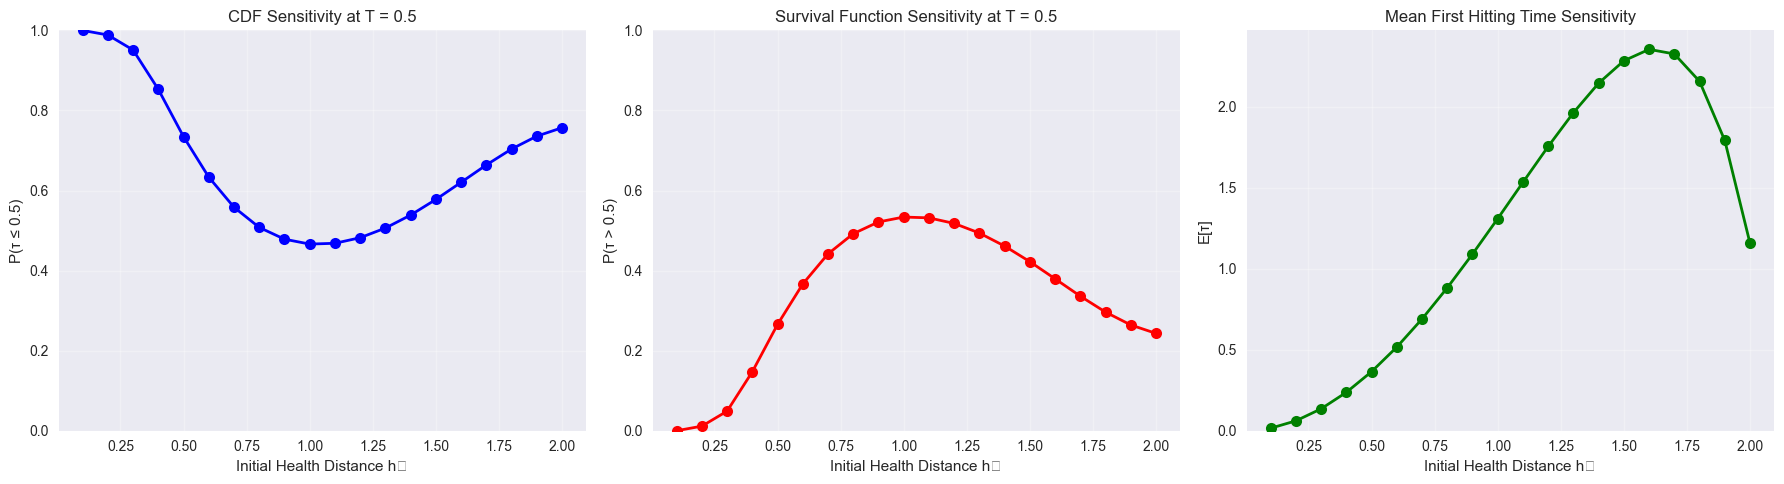

In [10]:
# Plot sensitivity analysis results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# CDF sensitivity
axes[0].plot(sensitivity_results['h0_values'], sensitivity_results['cdf_at_T'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Initial Health Distance h₀')
axes[0].set_ylabel(f'P(τ ≤ {T_test})')
axes[0].set_title(f'CDF Sensitivity at T = {T_test}')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Survival function sensitivity
axes[1].plot(sensitivity_results['h0_values'], sensitivity_results['survival_at_T'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Initial Health Distance h₀')
axes[1].set_ylabel(f'P(τ > {T_test})')
axes[1].set_title(f'Survival Function Sensitivity at T = {T_test}')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

# Mean hitting time sensitivity
valid_means = [m for m in sensitivity_results['mean_hitting_time'] if not np.isnan(m)]
valid_h0 = [h for h, m in zip(sensitivity_results['h0_values'], sensitivity_results['mean_hitting_time']) if not np.isnan(m)]

if len(valid_means) > 0:
    axes[2].plot(valid_h0, valid_means, 'go-', linewidth=2, markersize=8)
    axes[2].set_xlabel('Initial Health Distance h₀')
    axes[2].set_ylabel('E[τ]')
    axes[2].set_title('Mean First Hitting Time Sensitivity')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

## 7. Validation Tests

Validate the solver implementation with theoretical checks.

In [ ]:
# Validation tests
print("Validation Tests:")
print("=" * 50)

# Test 1: φ(0) = 1 (normalization)
validation_1 = solver.validate_solution(0.0, h0, lambda_X0, lambda_Y0)
print(f"Test 1 - Normalization φ(0) = 1: {validation_1['valid']}")
if validation_1['valid']:
    print(f"  |φ(0)| = {validation_1['phi_0_magnitude']:.8f}")
    print(f"  Error = {validation_1['normalization_error']:.2e}")
else:
    print(f"  Error: {validation_1['error']}")

# Test 2: φ(s) computation for various s values
test_s_values = [0.1, 0.5, 1.0, 2.0]
print(f"\nTest 2 - Characteristic function computation:")
for s_test in test_s_values:
    validation = solver.validate_solution(s_test, h0, lambda_X0, lambda_Y0)
    status = "✓" if validation['valid'] else "✗"
    print(f"  s = {s_test}: {status}")
    if not validation['valid']:
        print(f"    Error: {validation['error']}")

# Test 3: CDF monotonicity
T_mono_test = [0.5, 1.0, 2.0, 5.0]
cdf_mono_test = [solver.gil_pelaez_cdf(T, h0, lambda_X0, lambda_Y0) for T in T_mono_test]
is_monotonic = all(cdf_mono_test[i] <= cdf_mono_test[i+1] for i in range(len(cdf_mono_test)-1))
print(f"\nTest 3 - CDF monotonicity: {'✓' if is_monotonic else '✗'}")
print(f"  CDF values: {[f'{cdf:.4f}' for cdf in cdf_mono_test]}")

# Test 4: CDF bounds [0,1]
cdf_bounds_ok = all(0 <= cdf <= 1 for cdf in cdf_mono_test)
print(f"\nTest 4 - CDF bounds [0,1]: {'✓' if cdf_bounds_ok else '✗'}")

print(f"\nOverall validation: {'✓ PASSED' if all([validation_1['valid'], is_monotonic, cdf_bounds_ok]) else '✗ FAILED'}")

## Summary

This notebook demonstrated the complete usage of the 12D first hitting time Riccati solver:

### Key Features Shown:

1. **Parameter Configuration**: Loading and setting up the `FirstHittingTimeParameters`
2. **Characteristic Function**: Computing φ(s) = E[exp(isτ)] for the first hitting time τ
3. **Gil-Pelaez Inversion**: Using the inversion formula to compute CDF and PDF
4. **Moment Computation**: Computing mean and variance of the first hitting time
5. **Sensitivity Analysis**: Understanding parameter impact on hitting time distributions
6. **Validation Tests**: Ensuring mathematical correctness of the implementation

### Mathematical Framework:

- **12D Riccati System**: Second-order ODE system in real variables [ReA, ReA', ReB, ReB', ReC, ReC', ImA, ImA', ImB, ImB', ImC, ImC']
- **Characteristic Function**: φ(s) = exp(-isA(h₀) - B(h₀)λ_X₀ - C(h₀)λ_Y₀)
- **Gil-Pelaez Formula**: F(T) = 0.5 - (1/π) ∫₀^∞ Im[e^{-isT} φ(s) / s] ds

### Applications:

This solver is essential for:
- **Risk Management**: Computing liquidation probabilities in DeFi lending
- **Portfolio Optimization**: Understanding first passage time distributions
- **Stress Testing**: Analyzing extreme scenarios with jump-diffusion dynamics
- **Parameter Calibration**: Fitting models to observed liquidation data